# Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Lambda, LSTM, GRU
from sklearn.metrics import cohen_kappa_score

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Importation

In [2]:
dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')

In [3]:
dfx.head()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
0,53,0.166262,0.170520,0.176371,0.197565,0.212814,0.957631,1.177679,3.207268,3.213602,...,14.700766,15.856531,15.906414,15.910547,16.079702,16.516175,16.988851,16.996101,17.019988,17.056403
1,7229,0.053270,0.133652,0.161603,0.530531,0.692537,0.730291,0.784066,1.023311,1.059203,...,10.420048,11.577627,18.070029,18.825891,19.248378,19.539560,19.723312,19.978294,20.052356,20.123709
2,7770,0.600593,1.127467,1.289813,2.598660,3.826711,4.851020,5.025722,5.262254,5.282915,...,24.635121,25.967167,26.270768,28.028523,29.584844,31.183257,31.218086,31.285777,33.160938,33.360947
3,7002,0.136037,0.655734,0.992514,1.490964,2.246825,2.855319,3.208054,3.325092,4.202108,...,13.473805,13.688518,14.028203,14.178543,14.783635,15.151632,16.003356,16.282885,17.249543,17.259610
4,7678,0.200614,0.257171,0.288137,0.314078,0.486903,0.499591,0.534961,0.623986,0.639313,...,11.298341,12.214740,13.072630,13.952573,14.013957,14.476091,14.724149,16.883795,17.052340,19.289922


In [4]:
dfy.head()

,TARGET
ID,
0,0
1,0
2,0
3,0
4,1


In [5]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

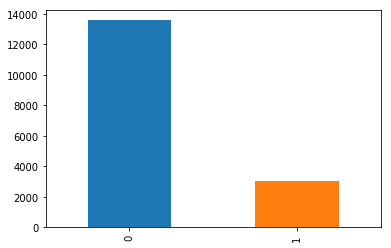

In [6]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [7]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
diff

[8046]

* **Create Xtrain Ytrain:** numpy array from df, with dimensions *(sample_nb, timestep_nb, feature_nb)*

In [35]:
# X: Exclude neuron_id column from array
X = dfx.iloc[:,1:].values
X = X[..., np.newaxis]

# Y: Delete useless dimension 
Y = dfy.values
Y = np.reshape(Y, (Y.shape[0],))
#Y = Y.tolist()
Y[:5]

array([0, 0, 0, 0, 1])

* **Balance dataset:** Under-sample class2 to have same number of samples in both classes

In [36]:
# Extract class2 indices from Y
Y_class1_ix = np.where(Y == 1)[0]
Y_class2_ix = np.where(Y == 0)[0]
print(Y_class2_ix)

# Under-sample class2 to get balanced classes
Y_class2_ix_undersampled = np.random.choice(Y_class2_ix, len(Y_class1_ix))
print(Y_class2_ix_undersampled)

# Concatenate the undersampled_class2_array and the class1_array
balanced_ix = np.concatenate((Y_class1_ix, Y_class2_ix_undersampled), axis=0)
np.random.shuffle(balanced_ix)
print(balanced_ix)

[    0     1     2 ... 16631 16633 16634]
[3854 9262 9212 ...  820 8074 4282]
[ 8699   608 13157 ...  3794 16625  2016]


In [37]:
# Create a Xtrain and Xval dataset
split = 0.8
balanced_ix_train = np.random.choice(balanced_ix, round(split * balanced_ix.shape[0]))
balanced_ix_val = [x for x in balanced_ix if x not in balanced_ix_train]
X_train = X[balanced_ix_train]
Y_train = Y[balanced_ix_train]

* **Deprecated:** Concatenate neuron_id to every timestep of a sample 

In [10]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
"""
timesteps_arr = dfx.iloc[:,1:].values
timesteps_arr = timesteps_arr[..., np.newaxis]
timesteps_arr.shape

neuron_arr = dfx.iloc[:,0].values
neuron_arr.shape

neuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)
final_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)
final_arr.shape
"""

'\ntimesteps_arr = dfx.iloc[:,1:].values\ntimesteps_arr = timesteps_arr[..., np.newaxis]\ntimesteps_arr.shape\n\nneuron_arr = dfx.iloc[:,0].values\nneuron_arr.shape\n\nneuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)\nfinal_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)\nfinal_arr.shape\n'

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Code

### Deep-Learning 1: blunt RNN

In [38]:
timestamp_nb = 50
feature_nb = 1

input_shape = (timestamp_nb, feature_nb)
x = input_tensor = Input(input_shape)
x = LSTM(32, return_sequences=False)(x)
x = output_tensor = Dense(1)(x)
model = Model(input_tensor, output_tensor)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=5)

Epoch 1/5
16635/16635 [==============================] - 53s 3ms/step - loss: 0.1522
Epoch 2/5
16635/16635 [==============================] - 49s 3ms/step - loss: 0.1460
Epoch 3/5
16635/16635 [==============================] - 49s 3ms/step - loss: 0.1452
Epoch 4/5
16635/16635 [==============================] - 47s 3ms/step - loss: 0.1452
Epoch 5/5
16635/16635 [==============================] - 46s 3ms/step - loss: 0.1448


### Domain-knowledge 1: KNN with SPIKE- and ISI- synchronization distances